In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [6]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download NLTK data if needed
nltk.download('stopwords')

# Initialize the stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Text Preprocessing function


def preprocess_text(text):
    """
    Preprocesses the text by converting to lowercase, removing special characters,
    removing stopwords, and applying stemming.
    """
    # Lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize and remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    # Apply stemming
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)


def load_and_preprocess_data(file_path):
    """
    Load and preprocess the dataset, including text preprocessing and engagement normalization.
    """
    df = pd.read_csv('/content/Instagram_data.csv')

    # Fill missing values in 'Caption' and 'Hashtags' columns
    df['Caption'] = df['Caption'].fillna('')
    df['Hashtags'] = df['Hashtags'].fillna('')

    # Apply text preprocessing
    df['Caption'] = df['Caption'].apply(preprocess_text)
    df['Hashtags'] = df['Hashtags'].apply(preprocess_text)

    # Combine Caption and Hashtags for vectorization
    df['content'] = df['Caption'] + ' ' + df['Hashtags']

    # Normalize engagement metrics
    engagement_metrics = ['Likes', 'Comments',
                          'Shares', 'Saves', 'Profile Visits', 'Follows']
    scaler = MinMaxScaler()
    df[engagement_metrics] = scaler.fit_transform(df[engagement_metrics])

    return df, engagement_metrics


def vectorize_content(df, max_features=1000):
    """
    Vectorizes the content (combined Caption and Hashtags) using TF-IDF.
    """
    tfidf = TfidfVectorizer(stop_words='english', max_features=max_features)
    tfidf_matrix = tfidf.fit_transform(df['content'])
    return tfidf, tfidf_matrix


def recommend_posts(input_caption, df, tfidf, tfidf_matrix, engagement_features, engagement_weight=0.3, num_recommendations=5):
    """
    Recommends posts based on cosine similarity, with the option to prioritize engagement metrics.
    """
    # Preprocess the input caption
    input_caption_processed = preprocess_text(input_caption)

    # Vectorize the input caption
    input_caption_vector = tfidf.transform([input_caption_processed])

    # Create a zero array for engagement metrics for the input (since it's unknown)
    zeros_for_engagement = np.zeros(
        engagement_features.shape[1]).reshape(1, -1)

    # Create combined features for input
    input_combined_features = np.hstack(
        [input_caption_vector.toarray(), zeros_for_engagement])

    # Compute cosine similarity between input caption and dataset
    similarity_scores = cosine_similarity(input_combined_features, np.hstack(
        [tfidf_matrix.toarray(), engagement_features])).flatten()

    # Sort the posts by similarity scores
    similar_posts_indices = similarity_scores.argsort()[
        ::-1][:num_recommendations]

    # Return the top similar posts
    return df.iloc[similar_posts_indices]


# Load and preprocess the dataset
df, engagement_metrics = load_and_preprocess_data('Instagram_data.csv')

# Vectorize the content and get engagement features
tfidf, tfidf_matrix = vectorize_content(df)
engagement_features = df[engagement_metrics].values

# Example: Input caption to get recommendations
input_caption = "i want to be a data analyst"
recommended_posts = recommend_posts(
    input_caption, df, tfidf, tfidf_matrix, engagement_features, num_recommendations=5)

# Display recommended posts
print(recommended_posts[['Date', 'Caption',
      'Hashtags', 'Likes', 'Comments', 'Shares']])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


           Date                                            Caption  \
47   2022-01-26  visual data one valuabl skill everi data scien...   
88   2022-03-08  visual data one valuabl skill everi data scien...   
30   2022-01-09  googl search analysi one best data analysi pro...   
139  2022-04-28  best data scienc project idea economi want lea...   
174  2022-06-02  analyz data collect fit one use case data scie...   

                                              Hashtags     Likes  Comments  \
47   dataanalyt datasci data machinelearn datavisu ...  0.020802  0.107143   
88   dataanalyt datasci data machinelearn datavisu ...  0.020802  0.107143   
30   data datasci dataanalysi dataanalyt datascient...  0.070332  0.321429   
139  datasci datasciencejob datasciencetrain datasc...  0.160475  0.357143   
174  datasci datasciencejob datasciencetrain datasc...  0.207528  0.000000   

       Shares  
47   0.006356  
88   0.006356  
30   0.006356  
139  0.091102  
174  0.057203  


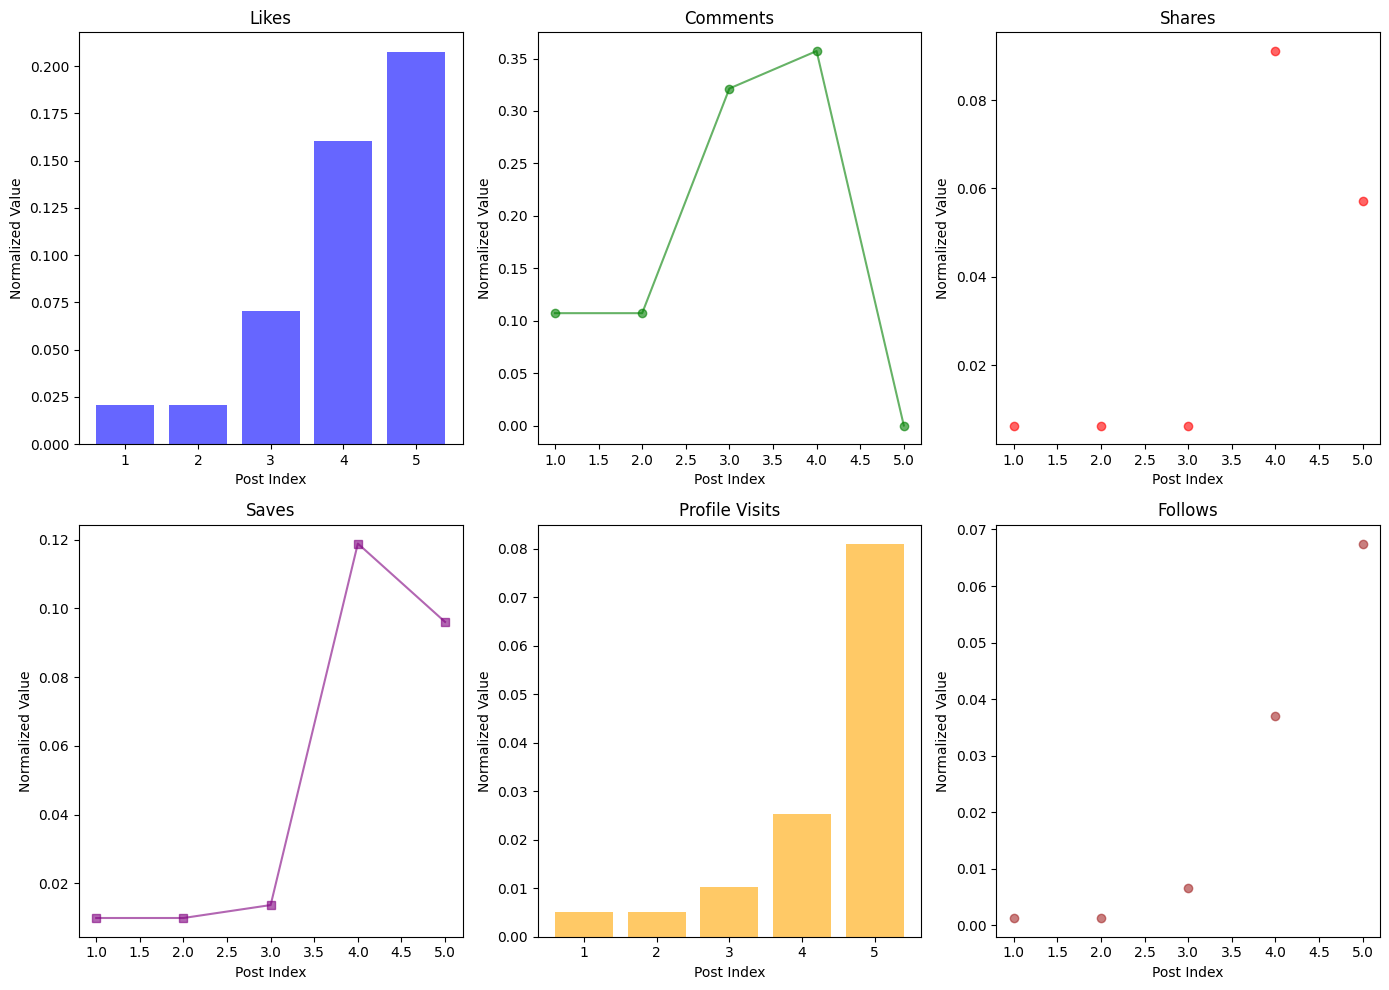

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize engagement metrics for the recommended posts


def visualize_recommended_post_metrics(recommended_posts):
    """
    Visualize multiple engagement metrics (Likes, Comments, Shares, Saves, Profile Visits, Follows) using various graphs.
    """
    num_recommendations = len(recommended_posts)
    post_indices = range(1, num_recommendations + 1)

    # Set up the figure for multiple subplots
    plt.figure(figsize=(14, 10))

    # Plot 1: Bar chart for Likes
    plt.subplot(2, 3, 1)
    plt.bar(post_indices, recommended_posts['Likes'], color='blue', alpha=0.6)
    plt.title('Likes')
    plt.xlabel('Post Index')
    plt.ylabel('Normalized Value')

    # Plot 2: Line plot for Comments
    plt.subplot(2, 3, 2)
    plt.plot(post_indices,
             recommended_posts['Comments'], marker='o', color='green', alpha=0.6)
    plt.title('Comments')
    plt.xlabel('Post Index')
    plt.ylabel('Normalized Value')

    # Plot 3: Scatter plot for Shares
    plt.subplot(2, 3, 3)
    plt.scatter(
        post_indices, recommended_posts['Shares'], color='red', alpha=0.6)
    plt.title('Shares')
    plt.xlabel('Post Index')
    plt.ylabel('Normalized Value')

    # Plot 4: Line plot for Saves
    plt.subplot(2, 3, 4)
    plt.plot(post_indices,
             recommended_posts['Saves'], marker='s', color='purple', alpha=0.6)
    plt.title('Saves')
    plt.xlabel('Post Index')
    plt.ylabel('Normalized Value')

    # Plot 5: Bar chart for Profile Visits
    plt.subplot(2, 3, 5)
    plt.bar(post_indices,
            recommended_posts['Profile Visits'], color='orange', alpha=0.6)
    plt.title('Profile Visits')
    plt.xlabel('Post Index')
    plt.ylabel('Normalized Value')

    # Plot 6: Scatter plot for Follows
    plt.subplot(2, 3, 6)
    plt.scatter(
        post_indices, recommended_posts['Follows'], color='brown', alpha=0.6)
    plt.title('Follows')
    plt.xlabel('Post Index')
    plt.ylabel('Normalized Value')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


# Example usage: Visualize engagement metrics for recommended posts
visualize_recommended_post_metrics(recommended_posts)

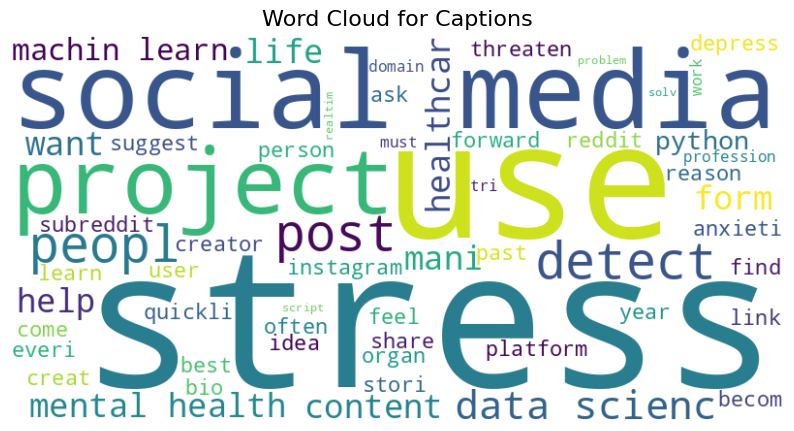

<ipython-input-4-a44bbba4c52d>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hashtag_freq.values, y=hashtag_freq.index, palette="viridis")


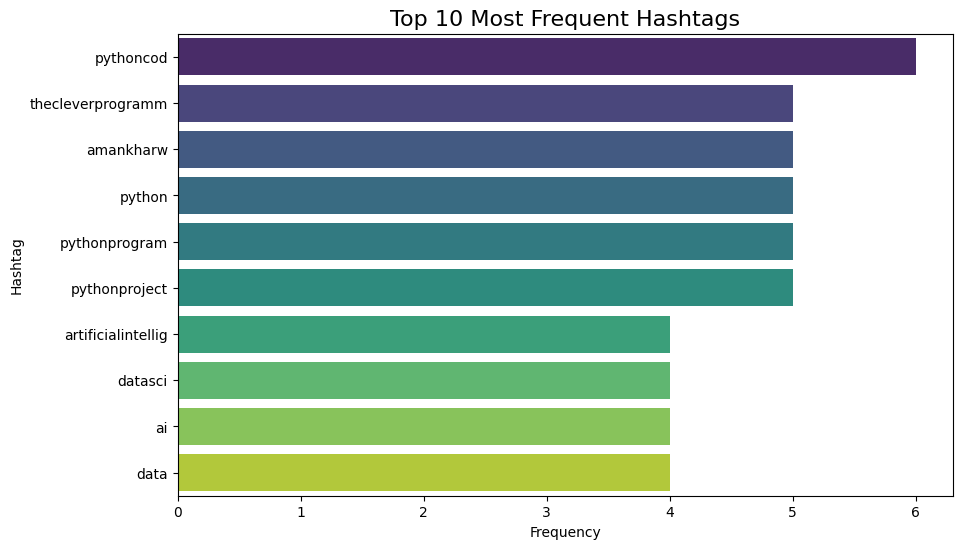

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Function to generate word cloud for Captions


def visualize_captions_wordcloud(recommended_posts):
    """
    Generates a word cloud for the captions of the recommended posts.
    """
    all_captions = ' '.join(recommended_posts['Caption'])
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white').generate(all_captions)

    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title('Word Cloud for Captions', fontsize=16)
    plt.show()

# Function to generate bar chart for Hashtags


def visualize_hashtags_bar(recommended_posts):
    """
    Generates a bar chart showing the frequency of hashtags used in the recommended posts.
    """
    # Split hashtags into individual words and count frequency
    all_hashtags = ' '.join(recommended_posts['Hashtags']).split()
    hashtag_freq = pd.Series(all_hashtags).value_counts().head(
        10)  # Top 10 most frequent hashtags

    # Create bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=hashtag_freq.values, y=hashtag_freq.index, palette="viridis")
    plt.title('Top 10 Most Frequent Hashtags', fontsize=16)
    plt.xlabel('Frequency')
    plt.ylabel('Hashtag')
    plt.show()


# Example usage: Visualize captions word cloud and hashtags bar chart
visualize_captions_wordcloud(recommended_posts)
visualize_hashtags_bar(recommended_posts)

In [8]:
# Function to display the top N recommended posts in a DataFrame format
def display_recommended_posts(recommended_posts):
    """
    Displays the recommended posts with important columns like Date, Caption, Hashtags, and engagement metrics.
    """
    return recommended_posts[['Date', 'Caption', 'Hashtags', 'Likes', 'Comments', 'Shares']]


# Example usage: Get a DataFrame of the recommended posts
recommended_posts_df = display_recommended_posts(recommended_posts)
recommended_posts_df

,Date,Caption,Hashtags,Likes,Comments,Shares
47,2022-01-26,visual data one valuabl skill everi data scien...,dataanalyt datasci data machinelearn datavisu ...,0.020802,0.107143,0.006356
88,2022-03-08,visual data one valuabl skill everi data scien...,dataanalyt datasci data machinelearn datavisu ...,0.020802,0.107143,0.006356
30,2022-01-09,googl search analysi one best data analysi pro...,data datasci dataanalysi dataanalyt datascient...,0.070332,0.321429,0.006356
139,2022-04-28,best data scienc project idea economi want lea...,datasci datasciencejob datasciencetrain datasc...,0.160475,0.357143,0.091102
174,2022-06-02,analyz data collect fit one use case data scie...,datasci datasciencejob datasciencetrain datasc...,0.207528,0.000000,0.057203
